# CONTEXT :
The dataset was collected from PACS (Picture archiving and communication system) from different hospitals in Dhaka, Bangladesh where patients were already diagnosed with having a kidney tumor, cyst, normal or stone findings. Both the Coronal and Axial cuts were selected from both contrast and non-contrast studies with protocol for the whole abdomen and urogram. The Dicom study was then carefully selected, one diagnosis at a time, and from those we created a batch of Dicom images of the region of interest for each radiological finding. Following that, we excluded each patient's information and meta data from the Dicom images and converted the Dicom images to a lossless jpg image format. After the conversion, each image finding was again verified by a radiologist and a medical technologist to reconfirm the correctness of the data.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
base_dir = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
classes = ['Cyst', 'Tumor', 'Stone', 'Normal']

In [3]:
data = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(('jpg')):  
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))
df = pd.DataFrame(data, columns=['file_path', 'label'])
df.head()

,file_path,label
0,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
1,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
2,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
3,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
4,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  12446 non-null  object
 1   label      12446 non-null  object
dtypes: object(2)
memory usage: 194.6+ KB


In [5]:
df['label'].value_counts().reset_index()

,label,count
0,Normal,5077
1,Cyst,3709
2,Tumor,2283
3,Stone,1377


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

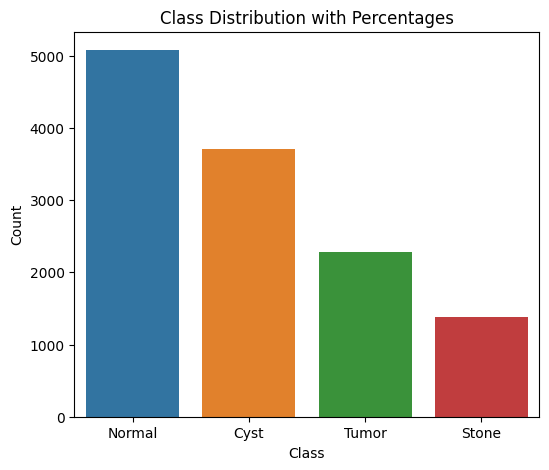

In [7]:
value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
plt.figure(figsize=(6,5))
ax = sns.barplot(data=value_counts, x='label', y='count')
plt.title("Class Distribution with Percentages")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [8]:
df=df.drop(df[df['label']=='Cyst'].head(2000).index)
df=df.drop(df[df['label']=='Tumor'].head(300).index)

In [9]:
df['target']=df['label'].apply(lambda x:0 if x=='Normal' else 1)
df['target'].value_counts()

target
0    5077
1    5069
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# BINARY CLASS MODEL

In [11]:
train, temp_df = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=42)
val, temp_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['target'], random_state=42)

In [12]:
print(f"Validation size: {len(val)}")
print(f"Training size: {len(train)}")

Validation size: 507
Training size: 9131


In [13]:
train['target'] = train['target'].astype(str)
val['target'] = val['target'].astype(str)
temp_df['target']=temp_df['target'].astype(str)

In [14]:
datagen = ImageDataGenerator(rescale=1.0/255)
training= datagen.flow_from_dataframe(
    train,
    x_col='file_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

validation = datagen.flow_from_dataframe(
    val,
    x_col='file_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

test = datagen.flow_from_dataframe(
    temp_df,
    x_col='file_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 9131 validated image filenames belonging to 2 classes.
Found 507 validated image filenames belonging to 2 classes.
Found 508 validated image filenames belonging to 2 classes.


In [15]:
binary_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [16]:
binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,705,249 (6.51 MB)

 Trainable params: 1,705,249 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
binary_model.compile(optimizer=Adam(learning_rate=0.00001),loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = binary_model.fit(
    training,
    epochs=10,
    validation_data=validation,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.6102 - loss: 0.6752 - val_accuracy: 0.8087 - val_loss: 0.5879
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8271 - loss: 0.5383 - val_accuracy: 0.8383 - val_loss: 0.4358
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.8614 - loss: 0.3958 - val_accuracy: 0.8600 - val_loss: 0.3563
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.8883 - loss: 0.3135 - val_accuracy: 0.8955 - val_loss: 0.2860
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9197 - loss: 0.2483 - val_accuracy: 0.9250 - val_loss: 0.2327
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9345 - loss: 0.1975 - val_accuracy: 0.9389 - val_loss: 0.1892
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.9535 - loss: 0.1614 - val_accuracy: 0.9546 - val_loss: 0.1532
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9619 - loss: 0.1325 - val_accuracy: 0.956

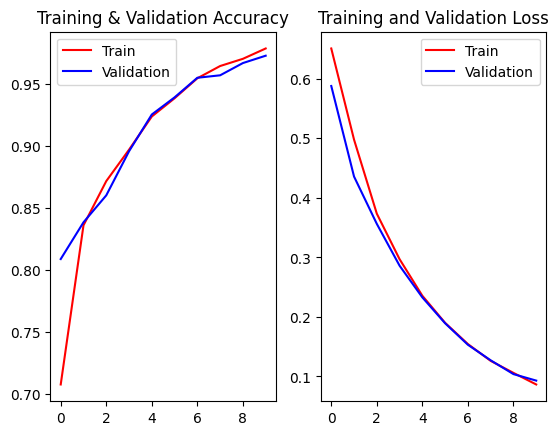

In [19]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='red',label='Train')
plt.plot(history.history['val_loss'], color='blue',label='Validation')
plt.title("Training and Validation Loss")
plt.legend()


In [20]:
test_loss_binary, test_accuracy_binary = binary_model.evaluate(test)
y_pred = binary_model.predict(test)  
print(f"Loss: {test_loss_binary}")
print(f"Accuracy: {test_accuracy_binary}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9848 - loss: 0.0798
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 886ms/step
Loss: 0.07766643166542053
Accuracy: 0.9842519760131836


In [21]:
y_true = test.classes
y_pred = (y_pred > 0.5).astype(int)
results_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred.flatten()
})

In [22]:
results_df.head(10)

,True_Label,Predicted_Label
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,0,0


In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       254
           1       0.98      0.99      0.98       254

    accuracy                           0.98       508
   macro avg       0.98      0.98      0.98       508
weighted avg       0.98      0.98      0.98       508



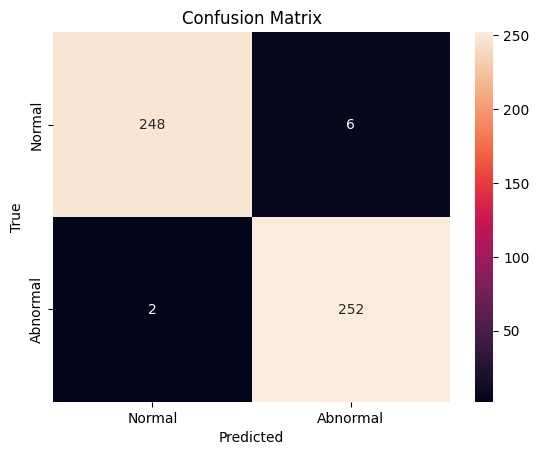

In [24]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Multi Class Model with VGG16  

In [25]:
abnormal_df = df[df['label'].isin(['Cyst', 'Stone', 'Tumor'])]
abnormal_df['label'].value_counts()


label
Tumor    1983
Cyst     1709
Stone    1377
Name: count, dtype: int64

In [26]:
abnormal_df['target'].value_counts()

target
1    5069
Name: count, dtype: int64

In [27]:
train_multi, temp_df = train_test_split(abnormal_df, test_size=0.1, stratify=abnormal_df['label'], random_state=42)
val_multi, test_multi = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [28]:
multiclass_train = datagen.flow_from_dataframe(
    train_multi,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
multiclass_val = datagen.flow_from_dataframe(
    val_multi,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
multiclass_test = datagen.flow_from_dataframe(
    test_multi,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 4562 validated image filenames belonging to 3 classes.
Found 253 validated image filenames belonging to 3 classes.
Found 254 validated image filenames belonging to 3 classes.


In [29]:
pretrained_model_multi = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights= None
)

pretrained_model_multi.trainable = False

VGG_model_multi = Sequential([
    pretrained_model_multi,                         
    Conv2D(64, (3, 3), activation='relu', padding='same'),  
    MaxPooling2D((2, 2)),                             
    Flatten(),                                         
    Dense(64, activation='relu'),                   
    Dense(32, activation='relu'),                    
    Dense(3, activation='softmax')                  
])


In [30]:
VGG_model_multi.compile(optimizer=Adam(learning_rate=0.001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [31]:
callbacks = [

    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]
history= VGG_model_multi.fit(multiclass_train,
                     validation_data=multiclass_val,
                     epochs=10,
                     callbacks=[callbacks])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 1493s 21s/step - accuracy: 0.3967 - loss: 1.0883 - val_accuracy: 0.3913 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1544s 21s/step - accuracy: 0.4260 - loss: 1.0561 - val_accuracy: 0.5652 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1490s 21s/step - accuracy: 0.5786 - loss: 0.8975 - val_accuracy: 0.6285 - val_loss: 0.7434 - learning_rate: 0.0010
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1469s 20s/step - accuracy: 0.6598 - loss: 0.7122 - val_accuracy: 0.6601 - val_loss: 0.6410 - learning_rate: 0.0010
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1476s 20s/step - accuracy: 0.7363 - loss: 0.5986 - val_accuracy: 0.7352 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1465s 20s/step - accuracy: 0.8037 - loss: 0.4898 - val_accuracy: 0.8103 - val_loss: 0.4406 - learning_rate: 0.0010
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1467s 20s/step - accuracy: 0.8530 - loss: 0.3987 - val_

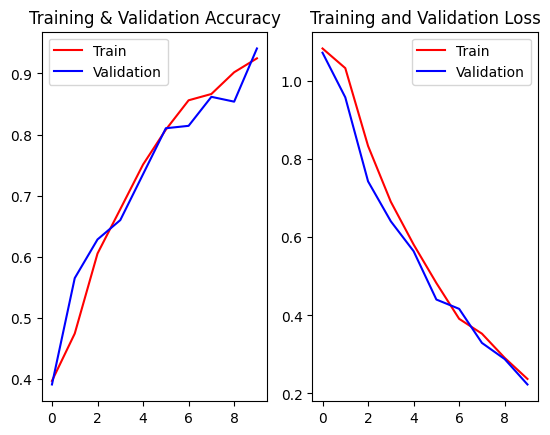

In [32]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='red',label='Train')
plt.plot(history.history['val_loss'], color='blue',label='Validation')
plt.title("Training and Validation Loss")
plt.legend()


In [37]:
y_pred_probs = VGG_model_multi.predict(multiclass_test) 
y_pred = y_pred_probs.argmax(axis=1)
y_true = multiclass_test.classes 

4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


In [39]:
results_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})
results_df.head()

,True_Label,Predicted_Label
0,2,2
1,0,1
2,2,2
3,0,0
4,1,1


In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        86
           1       0.87      0.97      0.92        69
           2       1.00      1.00      1.00        99

    accuracy                           0.95       254
   macro avg       0.95      0.95      0.95       254
weighted avg       0.96      0.95      0.95       254



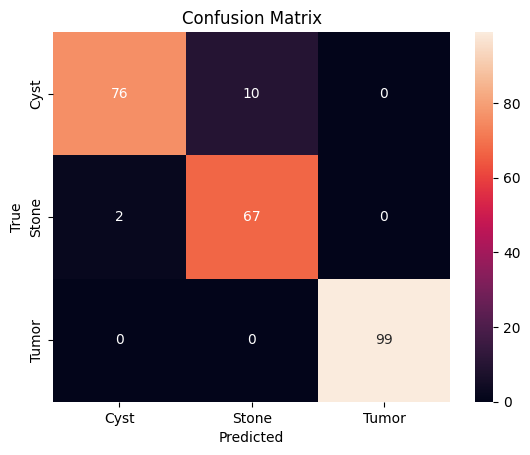

In [41]:
cm = confusion_matrix(y_true, y_pred)
classes = ["Cyst", "Stone", "Tumor"]
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# OBSERVATIONS:
* Data consists of file_path along with the lables columns
* In the first model we convert the multi class labels column to binary class
  labels columns and constructed a CNN model with 4 convolution layers
* We get 97% Accuracy from the binary model
* In the second model we take the VGG16 model for multi class classification
  and we get 93% Accuracy 